## If I Could Churn Back Time

... we wouldn't need these models, gnome sayin'?

# Overview

For my capstone project, I have chosen to continue in a similar vein to my Phase 3 project with entirely different data. Churn, which is what it is called when a customer stops doing business with a company, is one of the largest issues facing almost every industry today. In context of subscription industries, for example, "churn" is a massive ongoing issue, as it is infinitely cheaper to keep existing customers than to lure in new ones.

# Business Understanding

Therefore, establishing a procedure to keep customers from "churning" is of the utmost importance. The first step in this process is identifying the reasons behind customer churn, such as dissatisfaction, area of service provided, quality of service, and other such considerations. Following that, we will build a model that will accurately predict whether or not a customer will churn, and thereby provide the limitlessly valuable opportunity for a company to prevent that churn.

# Data Understanding & Preparation

The data we've used for this endeavor comes to us from IBM, and is a publicly available dataset created for this exact purpose - to help deal with churn problems, and allow students like me to cut our teeth on such before we enter the wider world of data science. This sample data module tracks a fictional Telco company's customer churn based on a variety of possible factors, such as gender, monthly charges, and usage information, as well as whether the customer churned or not. Due to the nature of the data we used, any location based features were excluded because the data was all centered in California specifically.

In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn import tree
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

Our first step in data understanding is to load in our various Excel spreadsheets and transform them into Pandas dataframes to be explored. Our first exploratory steps will inform the rest of the process from cleaning the data to modeling, all the way to our final recommendations.

In [2]:
churn_df = pd.read_excel('Data/CustomerChurn.xlsx')

In [3]:
churn_df

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,845894,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,503388,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,810338,6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,230811,2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,155157,4801-JZAZL,No,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,731782,8361-LTMKD,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [4]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LoyaltyID          7043 non-null   int64  
 1   Customer ID        7043 non-null   object 
 2   Senior Citizen     7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   Tenure             7043 non-null   int64  
 6   Phone Service      7043 non-null   object 
 7   Multiple Lines     7043 non-null   object 
 8   Internet Service   7043 non-null   object 
 9   Online Security    7043 non-null   object 
 10  Online Backup      7043 non-null   object 
 11  Device Protection  7043 non-null   object 
 12  Tech Support       7043 non-null   object 
 13  Streaming TV       7043 non-null   object 
 14  Streaming Movies   7043 non-null   object 
 15  Contract           7043 non-null   object 
 16  Paperless Billing  7043 

In [5]:
churn_df.isna().sum()

LoyaltyID            0
Customer ID          0
Senior Citizen       0
Partner              0
Dependents           0
Tenure               0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn                0
dtype: int64

Right off the bat with our first dataframe, we can see that there are no null values and that our dataframe contains floats and ints (which are numbers) and objects. Something to note is that "Total Charges" is listed as an object and it likely ought to be an int or a float. After some fiddling, it became clear that this was going to be troublesome, but I found myself in luck - our third dataset has properly formatted information about charges for various services as well as total charges overall, so we will not need to keep that information in this dataset at all.

In [6]:
churn_df = churn_df.drop(['LoyaltyID', 'Total Charges', 'Monthly Charges'], axis=1)

In [7]:
churn_df

,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Churn
0,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,No
7039,2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),No
7040,4801-JZAZL,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
7041,8361-LTMKD,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,Yes


Now, we will repeat these same steps with the other relevant datasets.

In [8]:
telco_churn = pd.read_excel('Data/Telco_customer_churn.xlsx')

In [9]:
telco_churn

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,...,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No,0,45,5306,NaN
7039,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,...,One year,Yes,Mailed check,84.80,1990.5,No,0,59,2140,NaN
7040,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,One year,Yes,Credit card (automatic),103.20,7362.9,No,0,71,5560,NaN
7041,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,...,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,59,2793,NaN


In [10]:
telco_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

There are a few immediate issues with this dataframe. Firstly, while "Churn Reason" seems like it might be very useful for modeling purposes, the column is also full of nulls, and so must be removed. Any location information can be removed because this dataset is based entirely in California, so any location-based reasonings would not be sound. We must also compare this dataframe to the first one and remove any duplicate or unnecessary columns, for ease of merging the two dataframes into one useful one.

In [11]:
telco_churn = telco_churn.drop(['Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Reason'], axis=1)

In [12]:
telco_churn

,CustomerID,Gender,Churn Value,Churn Score,CLTV
0,3668-QPYBK,Male,1,86,3239
1,9237-HQITU,Female,1,67,2701
2,9305-CDSKC,Female,1,86,5372
3,7892-POOKP,Female,1,84,5003
4,0280-XJGEX,Male,1,89,5340
...,...,...,...,...,...
7038,2569-WGERO,Female,0,45,5306
7039,6840-RESVB,Male,0,59,2140
7040,2234-XADUH,Female,0,71,5560
7041,4801-JZAZL,Female,0,59,2793


In [13]:
telco_churn = telco_churn.rename(columns={'CustomerID': 'Customer ID'})

In [14]:
telco_churn

,Customer ID,Gender,Churn Value,Churn Score,CLTV
0,3668-QPYBK,Male,1,86,3239
1,9237-HQITU,Female,1,67,2701
2,9305-CDSKC,Female,1,86,5372
3,7892-POOKP,Female,1,84,5003
4,0280-XJGEX,Male,1,89,5340
...,...,...,...,...,...
7038,2569-WGERO,Female,0,45,5306
7039,6840-RESVB,Male,0,59,2140
7040,2234-XADUH,Female,0,71,5560
7041,4801-JZAZL,Female,0,59,2793


In [15]:
telco_churn.isna().sum()

Customer ID    0
Gender         0
Churn Value    0
Churn Score    0
CLTV           0
dtype: int64

Now, both of these dataframes are ready to be merged together, using Customer ID as a joining point since they are shared between them. This will add a few more features to our eventual modeling process, and I am specifically interested in gender as a feature here simply because it will be fascinating to see whether gender has any bearing on whether or not a customer stopped doing business with a company. I doubt it, but it is a unique viewpoint to consider.

We do have one final dataset that contains a few more services that could be used as features for modeling to determine whether those services (or lack thereof) have any impact on whether a customer will churn or not, so now, we will go through the same process one last time to assemble a third cleaned dataframe for our modeling purposes.

In [16]:
services_df = pd.read_excel('Data/Telco_customer_churn_services.xlsx')

In [17]:
services_df

,Service ID,Customer ID,Count,Quarter,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,...,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,IJKDQVSWH3522,8779-QRDMV,1,Q3,No,0,1,None,No,0.00,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65
1,BFKMZJAIE2285,7495-OOKFY,1,Q3,Yes,1,8,Offer E,Yes,48.85,...,Yes,Month-to-Month,Yes,Credit Card,80.65,633.30,0.00,0,390.80,1024.10
2,EIMVJQBMT7187,1658-BYGOY,1,Q3,No,0,18,Offer D,Yes,11.33,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88
3,EROZQXDUU4979,4598-XLKNJ,1,Q3,Yes,1,25,Offer C,Yes,19.76,...,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07
4,GEEYSJUHY6991,4846-WHAFZ,1,Q3,Yes,1,37,Offer C,Yes,6.33,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,JIVEOZUQQ2296,2569-WGERO,1,Q3,No,0,72,None,Yes,22.77,...,No,Two Year,Yes,Bank Withdrawal,21.15,1419.40,19.31,0,1639.44,3039.53
7039,OIQWIUTDY3518,6840-RESVB,1,Q3,Yes,1,24,Offer C,Yes,36.05,...,Yes,One Year,Yes,Mailed Check,84.80,1990.50,48.23,0,865.20,2807.47
7040,QSHQPZAYF6519,2234-XADUH,1,Q3,Yes,4,72,None,Yes,29.66,...,Yes,One Year,Yes,Credit Card,103.20,7362.90,45.38,0,2135.52,9453.04
7041,PMJLYZGVQ7211,4801-JZAZL,1,Q3,Yes,1,11,None,No,0.00,...,Yes,Month-to-Month,Yes,Bank Withdrawal,29.60,346.45,27.24,0,0.00,319.21


In [18]:
services_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Service ID                         7043 non-null   object 
 1   Customer ID                        7043 non-null   object 
 2   Count                              7043 non-null   int64  
 3   Quarter                            7043 non-null   object 
 4   Referred a Friend                  7043 non-null   object 
 5   Number of Referrals                7043 non-null   int64  
 6   Tenure in Months                   7043 non-null   int64  
 7   Offer                              7043 non-null   object 
 8   Phone Service                      7043 non-null   object 
 9   Avg Monthly Long Distance Charges  7043 non-null   float64
 10  Multiple Lines                     7043 non-null   object 
 11  Internet Service                   7043 non-null   objec

In [19]:
services_df.isna().sum()

Service ID                           0
Customer ID                          0
Count                                0
Quarter                              0
Referred a Friend                    0
Number of Referrals                  0
Tenure in Months                     0
Offer                                0
Phone Service                        0
Avg Monthly Long Distance Charges    0
Multiple Lines                       0
Internet Service                     0
Internet Type                        0
Avg Monthly GB Download              0
Online Security                      0
Online Backup                        0
Device Protection Plan               0
Premium Tech Support                 0
Streaming TV                         0
Streaming Movies                     0
Streaming Music                      0
Unlimited Data                       0
Contract                             0
Paperless Billing                    0
Payment Method                       0
Monthly Charge           

As a final step in our data understanding, we will remove any columns that are unnecessary or contain information that we already have in our other two available dataframes. This way, we will prevent overlapping of information and inaccurate feature impact on our modeling later.

In [20]:
services_df = services_df.drop(['Service ID', 'Count', 'Quarter', 'Tenure in Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method'], axis=1)

In [21]:
services_df

,Customer ID,Referred a Friend,Number of Referrals,Offer,Avg Monthly Long Distance Charges,Internet Type,Avg Monthly GB Download,Streaming Music,Unlimited Data,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,8779-QRDMV,No,0,None,0.00,DSL,8,No,No,39.65,39.65,0.00,20,0.00,59.65
1,7495-OOKFY,Yes,1,Offer E,48.85,Fiber Optic,17,No,Yes,80.65,633.30,0.00,0,390.80,1024.10
2,1658-BYGOY,No,0,Offer D,11.33,Fiber Optic,52,Yes,Yes,95.45,1752.55,45.61,0,203.94,1910.88
3,4598-XLKNJ,Yes,1,Offer C,19.76,Fiber Optic,12,No,Yes,98.50,2514.50,13.43,0,494.00,2995.07
4,4846-WHAFZ,Yes,1,Offer C,6.33,Fiber Optic,14,No,Yes,76.50,2868.15,0.00,0,234.21,3102.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,No,0,None,22.77,None,0,No,No,21.15,1419.40,19.31,0,1639.44,3039.53
7039,6840-RESVB,Yes,1,Offer C,36.05,Cable,24,Yes,Yes,84.80,1990.50,48.23,0,865.20,2807.47
7040,2234-XADUH,Yes,4,None,29.66,Fiber Optic,59,Yes,Yes,103.20,7362.90,45.38,0,2135.52,9453.04
7041,4801-JZAZL,Yes,1,None,0.00,DSL,17,No,Yes,29.60,346.45,27.24,0,0.00,319.21


In [22]:
services_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Referred a Friend                  7043 non-null   object 
 2   Number of Referrals                7043 non-null   int64  
 3   Offer                              7043 non-null   object 
 4   Avg Monthly Long Distance Charges  7043 non-null   float64
 5   Internet Type                      7043 non-null   object 
 6   Avg Monthly GB Download            7043 non-null   int64  
 7   Streaming Music                    7043 non-null   object 
 8   Unlimited Data                     7043 non-null   object 
 9   Monthly Charge                     7043 non-null   float64
 10  Total Charges                      7043 non-null   float64
 11  Total Refunds                      7043 non-null   float

In [23]:
services_df.isna().sum()

Customer ID                          0
Referred a Friend                    0
Number of Referrals                  0
Offer                                0
Avg Monthly Long Distance Charges    0
Internet Type                        0
Avg Monthly GB Download              0
Streaming Music                      0
Unlimited Data                       0
Monthly Charge                       0
Total Charges                        0
Total Refunds                        0
Total Extra Data Charges             0
Total Long Distance Charges          0
Total Revenue                        0
dtype: int64

Now, throughout all this data exploration and preparation, we have created three separate dataframes with one common column ("Customer ID"), 7043 entries that correspond to each other in each of the three dataframes, and various information on their services, plans, and habits. At this point, we must weld together those three separate dataframes into one usable one, and then begin the analysis process.

In [24]:
churn_df_2 = churn_df.merge(telco_churn, how="inner", on='Customer ID')

In [25]:
churn_df_2

,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Churn,Gender,Churn Value,Churn Score,CLTV
0,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,No,Female,0,27,3964
1,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,No,Male,0,61,3441
2,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,Yes,Male,1,86,3239
3,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),No,Male,0,66,4307
4,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,Yes,Female,1,67,2701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Yes,Yes,One year,Yes,Mailed check,No,Male,0,59,2140
7039,2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,One year,Yes,Credit card (automatic),No,Female,0,71,5560
7040,4801-JZAZL,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,No,No,Month-to-month,Yes,Electronic check,No,Female,0,59,2793
7041,8361-LTMKD,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Mailed check,Yes,Male,1,77,5839


In [26]:
churn_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Customer ID        7043 non-null   object
 1   Senior Citizen     7043 non-null   object
 2   Partner            7043 non-null   object
 3   Dependents         7043 non-null   object
 4   Tenure             7043 non-null   int64 
 5   Phone Service      7043 non-null   object
 6   Multiple Lines     7043 non-null   object
 7   Internet Service   7043 non-null   object
 8   Online Security    7043 non-null   object
 9   Online Backup      7043 non-null   object
 10  Device Protection  7043 non-null   object
 11  Tech Support       7043 non-null   object
 12  Streaming TV       7043 non-null   object
 13  Streaming Movies   7043 non-null   object
 14  Contract           7043 non-null   object
 15  Paperless Billing  7043 non-null   object
 16  Payment Method     7043 non-null   object


Our final step in merging these dataframes is to combine the dataframe we just made with the third and final dataframe to create one fully meshed dataset that we can then use for modeling. Because of the steps we took during this preprocessing and exploration, we now have no nulls and properly arranged data, to make the process of modeling much easier going forward.

In [27]:
final_df = churn_df_2.merge(services_df, how="inner", on='Customer ID')

In [28]:
final_df

,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Internet Type,Avg Monthly GB Download,Streaming Music,Unlimited Data,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,Yes,...,DSL,10,No,Yes,29.85,29.85,0.00,0,0.00,29.85
1,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,...,DSL,16,No,Yes,56.95,1889.50,0.00,0,581.06,2470.56
2,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,...,DSL,21,No,Yes,53.85,108.15,0.00,0,20.94,129.09
3,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,No,...,DSL,10,No,Yes,42.30,1840.75,0.00,0,0.00,1840.75
4,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,No,...,Fiber Optic,51,No,Yes,70.70,151.65,0.00,0,18.24,169.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Cable,24,Yes,Yes,84.80,1990.50,48.23,0,865.20,2807.47
7039,2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,Fiber Optic,59,Yes,Yes,103.20,7362.90,45.38,0,2135.52,9453.04
7040,4801-JZAZL,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,DSL,17,No,Yes,29.60,346.45,27.24,0,0.00,319.21
7041,8361-LTMKD,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,Fiber Optic,8,No,No,74.40,306.60,0.00,20,42.44,369.04


In [29]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Senior Citizen                     7043 non-null   object 
 2   Partner                            7043 non-null   object 
 3   Dependents                         7043 non-null   object 
 4   Tenure                             7043 non-null   int64  
 5   Phone Service                      7043 non-null   object 
 6   Multiple Lines                     7043 non-null   object 
 7   Internet Service                   7043 non-null   object 
 8   Online Security                    7043 non-null   object 
 9   Online Backup                      7043 non-null   object 
 10  Device Protection                  7043 non-null   object 
 11  Tech Support                       7043 non-null   objec

Et voila! One "perfect" dataframe with many various features that can be used to compare against "Churn" and "Churn Value", respectively, in order to determine how much of an impact those features have on whether a customer will or will not churn. As a final last prepatory step before we continue, we will remove the "Customer ID" column before we begin to model, as it is not necessary and will trip up our model.

In [30]:
final_df = final_df.drop(['Customer ID', 'Churn Value'], axis=1)

In [31]:
final_df

,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,...,Internet Type,Avg Monthly GB Download,Streaming Music,Unlimited Data,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,...,DSL,10,No,Yes,29.85,29.85,0.00,0,0.00,29.85
1,No,No,No,34,Yes,No,DSL,Yes,No,Yes,...,DSL,16,No,Yes,56.95,1889.50,0.00,0,581.06,2470.56
2,No,No,No,2,Yes,No,DSL,Yes,Yes,No,...,DSL,21,No,Yes,53.85,108.15,0.00,0,20.94,129.09
3,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,...,DSL,10,No,Yes,42.30,1840.75,0.00,0,0.00,1840.75
4,No,No,No,2,Yes,No,Fiber optic,No,No,No,...,Fiber Optic,51,No,Yes,70.70,151.65,0.00,0,18.24,169.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,...,Cable,24,Yes,Yes,84.80,1990.50,48.23,0,865.20,2807.47
7039,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,...,Fiber Optic,59,Yes,Yes,103.20,7362.90,45.38,0,2135.52,9453.04
7040,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,...,DSL,17,No,Yes,29.60,346.45,27.24,0,0.00,319.21
7041,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,...,Fiber Optic,8,No,No,74.40,306.60,0.00,20,42.44,369.04


In [32]:
final_df['Churn']

0        No
1        No
2       Yes
3        No
4       Yes
       ... 
7038     No
7039     No
7040     No
7041    Yes
7042     No
Name: Churn, Length: 7043, dtype: object

# Analysis

Now it is time to establish correlation between our features (those 35 mentioned) and our target ("Churn Label") so that we can proceed with modeling those features against that target in order to predict whether a customer will churn with the highest possible recall. Remember that recall is our important metric here rather than accuracy because it measures, in this context, which customers are predicted to churn versus which customers actually churned.

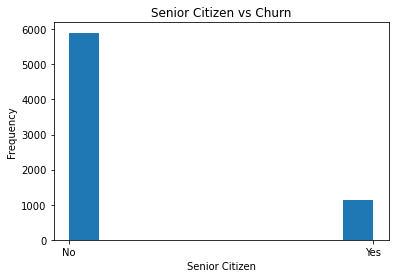

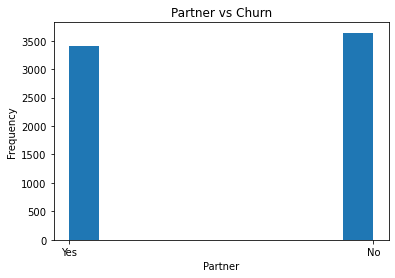

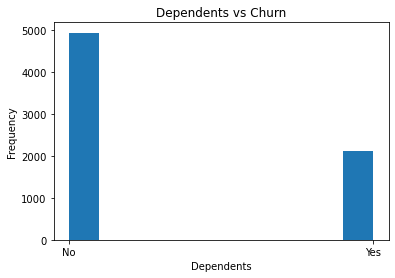

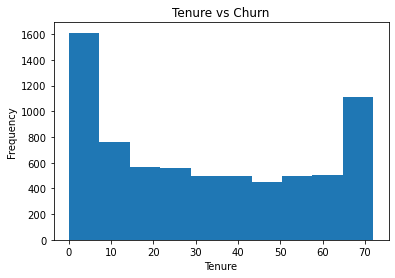

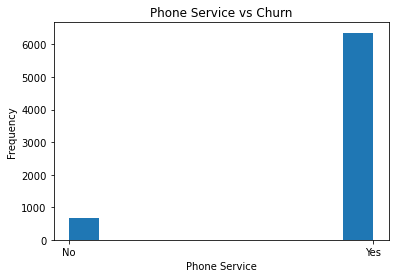

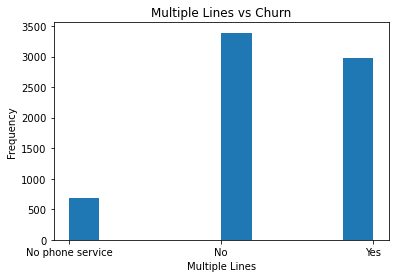

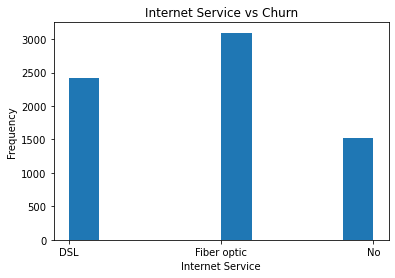

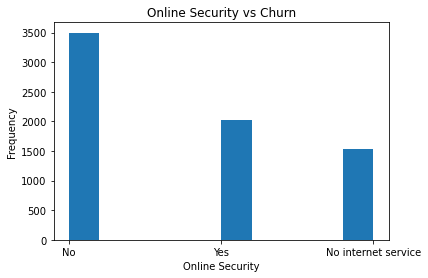

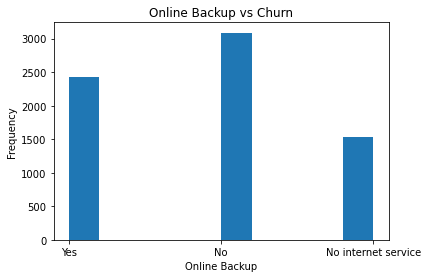

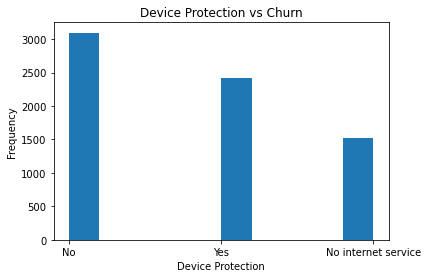

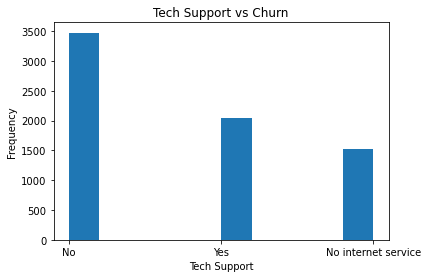

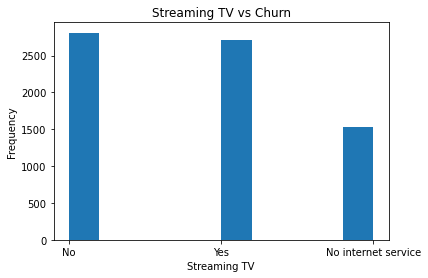

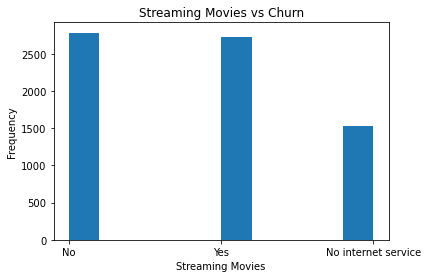

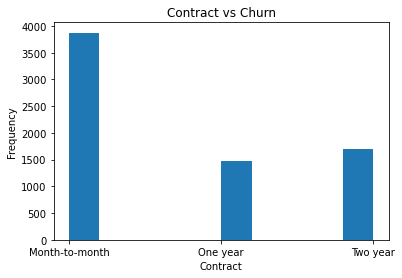

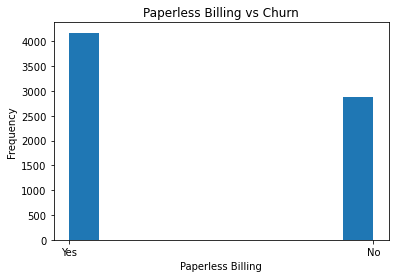

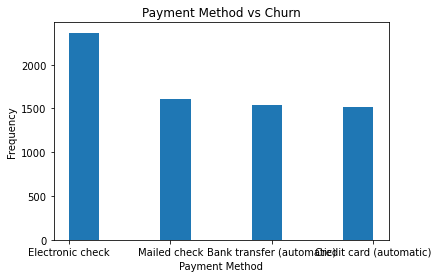

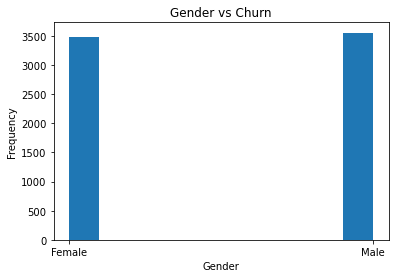

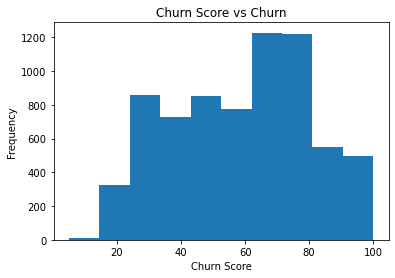

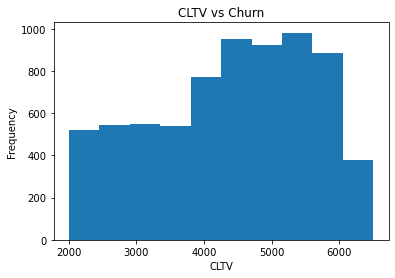

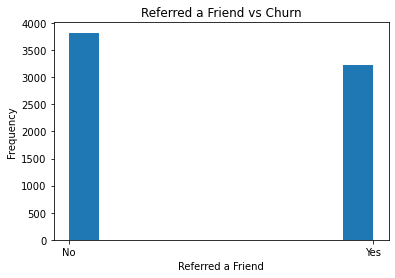

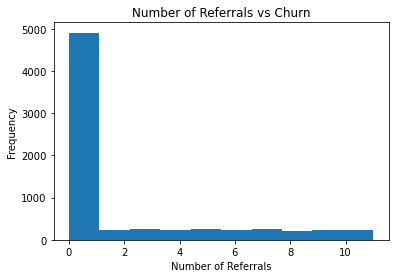

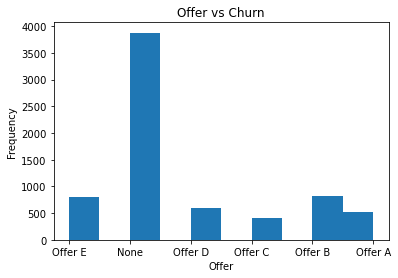

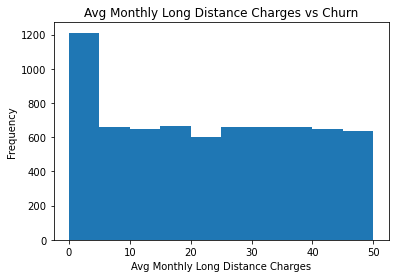

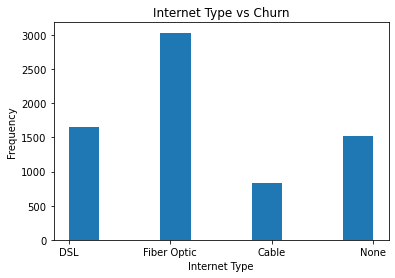

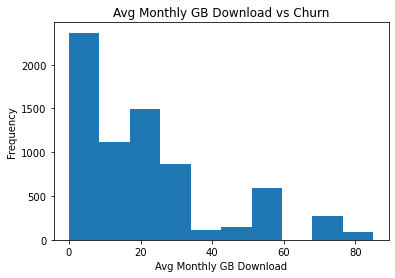

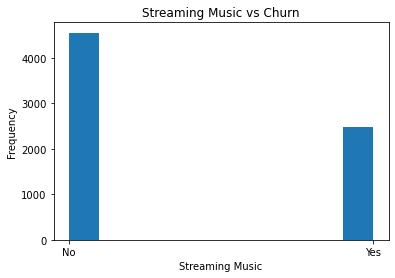

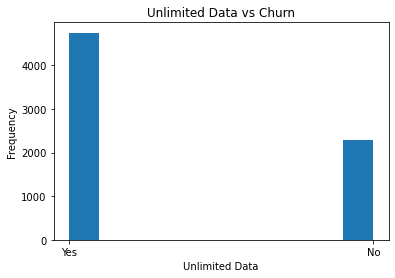

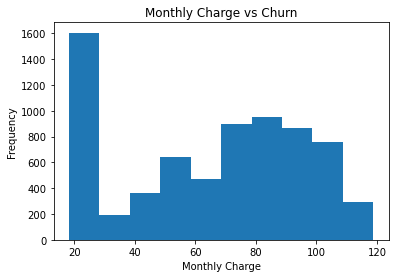

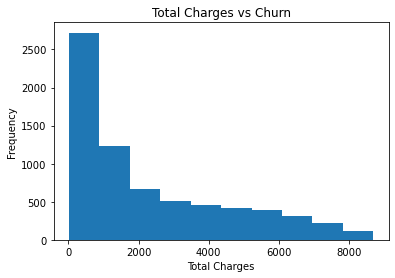

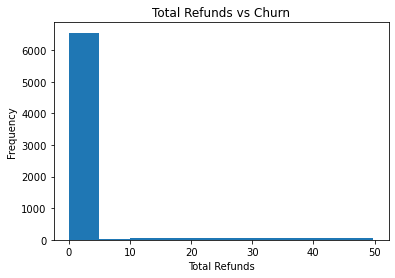

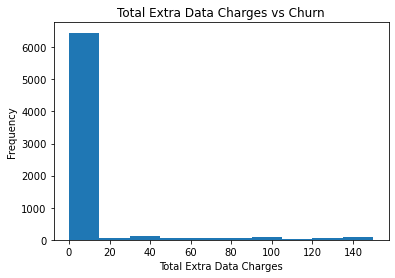

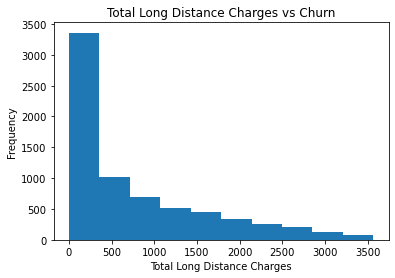

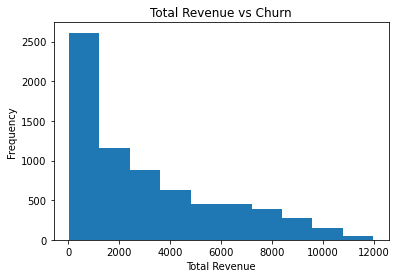

In [33]:
def plot_histograms(dataframe, target_column):
    for column in dataframe.columns:
        if column == target_column:
            continue
        plt.hist(dataframe[column])
        plt.title(f"{column} vs {target_column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()
        
plot_histograms(final_df, "Churn")

As can be easily viewed from these bar charts, these features have a varying impact on whether or not a customer will churn, and should provide plenty of usable data for the purpose! Just for the sake of being sure, however, we should remember that we can also use the .corr() method for our int and float column types to see the correlation there, as well. It is part of the reason we kept the category "Churn Value", as it was an integer version of the "Churn" object column.

In [34]:
final_df.corr()

,Tenure,Churn Score,CLTV,Number of Referrals,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
Tenure,1.000000,-0.224987,0.396406,0.326386,0.014705,0.049408,0.247900,0.826011,0.059137,0.082381,0.674083,0.853078
Churn Score,-0.224987,1.000000,-0.079782,-0.202738,0.022085,0.021885,0.133754,-0.123601,-0.013171,0.009107,-0.135793,-0.137772
CLTV,0.396406,-0.079782,1.000000,0.122843,0.023858,0.023043,0.098693,0.341947,0.007992,0.042540,0.282189,0.354198
Number of Referrals,0.326386,-0.202738,0.122843,1.000000,0.006336,0.038575,0.028173,0.250378,0.024756,0.000350,0.216190,0.261853
Avg Monthly Long Distance Charges,0.014705,0.022085,0.023858,0.006336,1.000000,-0.030455,0.138396,0.069500,-0.018644,0.002414,0.599828,0.232291
Avg Monthly GB Download,0.049408,0.021885,0.023043,0.038575,-0.030455,1.000000,0.391787,0.223268,0.002397,0.088939,0.011373,0.180726
Monthly Charge,0.247900,0.133754,0.098693,0.028173,0.138396,0.391787,1.000000,0.651236,0.033482,0.126244,0.246300,0.588887
Total Charges,0.826011,-0.123601,0.341947,0.250378,0.069500,0.223268,0.651236,1.000000,0.039558,0.121859,0.610185,0.972212
Total Refunds,0.059137,-0.013171,0.007992,0.024756,-0.018644,0.002397,0.033482,0.039558,1.000000,0.016755,0.028113,0.036984
Total Extra Data Charges,0.082381,0.009107,0.042540,0.000350,0.002414,0.088939,0.126244,0.121859,0.016755,1.000000,0.058871,0.122496


Now that we have established that our features do have some correlation as to whether or not a customer will churn, we can begin the modeling process with what might be our most important step - splitting our data into a test and training set, respectively. We do this because data leakage can cause a model to overperform. In other words, showing the test data to a model whilst it is training means that it is not truly telling us how well it performs on new data.

In [35]:
X = final_df.drop('Churn', axis=1)
y = final_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [36]:
X_train

,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,...,Internet Type,Avg Monthly GB Download,Streaming Music,Unlimited Data,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
6607,No,No,Yes,1,No,No phone service,DSL,No,No,No,...,Cable,51,No,No,25.30,25.30,0.0,10,0.00,35.30
2598,No,No,No,7,Yes,No,Fiber optic,No,No,Yes,...,Fiber Optic,10,No,No,75.15,525.00,0.0,10,210.42,745.42
2345,No,No,Yes,4,Yes,No,No,No internet service,No internet service,No internet service,...,None,0,No,No,20.05,85.50,0.0,0,109.48,194.98
4093,No,No,No,29,Yes,Yes,Fiber optic,No,No,No,...,Fiber Optic,42,No,Yes,76.00,2215.25,0.0,0,203.29,2418.54
693,No,No,No,3,Yes,Yes,Fiber optic,No,No,No,...,Fiber Optic,10,No,Yes,75.10,270.70,0.0,0,79.56,350.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,No,Yes,No,1,Yes,No,Fiber optic,Yes,No,No,...,Cable,5,Yes,Yes,95.00,95.00,0.0,0,12.04,107.04
5191,No,Yes,Yes,23,Yes,Yes,DSL,Yes,Yes,Yes,...,Cable,51,Yes,Yes,91.10,2198.30,0.0,0,643.31,2841.61
5226,No,Yes,Yes,12,Yes,No,No,No internet service,No internet service,No internet service,...,None,0,No,No,21.15,306.05,0.0,0,406.80,712.85
5390,Yes,No,No,12,Yes,Yes,Fiber optic,No,No,Yes,...,Fiber Optic,26,No,Yes,99.45,1200.15,0.0,0,262.68,1462.83


In [37]:
X_test

,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,...,Internet Type,Avg Monthly GB Download,Streaming Music,Unlimited Data,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
185,No,Yes,No,1,No,No phone service,DSL,No,No,No,...,DSL,29,Yes,Yes,24.80,24.80,0.0,0,0.00,24.80
2715,No,No,No,41,Yes,Yes,No,No internet service,No internet service,No internet service,...,None,0,No,No,25.25,996.45,0.0,0,1689.61,2686.06
3825,No,Yes,Yes,52,Yes,No,No,No internet service,No internet service,No internet service,...,None,0,No,No,19.35,1031.70,0.0,0,513.24,1544.94
1807,No,No,No,1,Yes,No,Fiber optic,No,No,Yes,...,Cable,9,No,Yes,76.35,76.35,0.0,0,7.26,83.61
132,No,No,No,67,Yes,No,DSL,No,No,No,...,DSL,8,No,Yes,50.55,3260.10,0.0,0,2182.86,5442.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,No,No,No,3,Yes,Yes,Fiber optic,No,No,No,...,Fiber Optic,23,No,No,75.80,246.30,0.0,10,15.60,271.90
2301,No,Yes,No,8,Yes,Yes,Fiber optic,No,No,No,...,Fiber Optic,4,Yes,No,90.25,743.75,0.0,0,79.04,822.79
5121,No,No,No,29,Yes,Yes,DSL,No,Yes,Yes,...,DSL,47,Yes,Yes,70.90,1964.60,0.0,0,836.07,2800.67
677,No,No,No,2,No,No phone service,DSL,No,No,No,...,DSL,76,Yes,Yes,34.70,62.25,0.0,0,0.00,62.25


Now, we will begin the modeling process by setting up a pipeline in order to scale our numerical features (such as Avg Monthly GB Download) to ensure that they are each taken with the same importance, and encoding our categorical features (such as Internet Service) to allow the model to parse through them properly. Many of our columns are actually Boolean, or "yes/no" data types, but they are listed as objects. Still, they will be able to be used in modeling just fine without any encoding, and we will not require any ordinal encoding as nothing here is in any sort of order. Essentially, the internet type ("Fiber optic", "DSL", or "no") has no listed order; there is no measurable numeric difference between "no" and "Fiber optic", so it does not need to be ordinally encoded.

In [38]:
le = LabelEncoder()

In [39]:
le.fit(y_train)

LabelEncoder()

In [40]:
encoded_y_train = le.fit_transform(y_train)

In [41]:
encoded_y = le.transform(y_test)

In [42]:
le.classes_

array(['No', 'Yes'], dtype=object)

In [43]:
num_feats = ['Tenure', 'Churn Score', 'CLTV', 'Number of Referrals', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue']
cat_feats = ['Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Payment Method', 'Offer', 'Internet Type']
ord_feats = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing', 'Gender', 'Referred a Friend', 'Streaming Music', 'Unlimited Data']

In [44]:
len(ord_feats)

9

We've encoded "Gender" as male (0) and female (1).

In [45]:
X_train.columns

Index(['Senior Citizen', 'Partner', 'Dependents', 'Tenure', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Gender', 'Churn Score', 'CLTV', 'Referred a Friend',
       'Number of Referrals', 'Offer', 'Avg Monthly Long Distance Charges',
       'Internet Type', 'Avg Monthly GB Download', 'Streaming Music',
       'Unlimited Data', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue'],
      dtype='object')

In [46]:
prep_pipeline = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), cat_feats),
        ('numeric', StandardScaler(), num_feats),
        ('other', OrdinalEncoder(categories=[['No', 'Yes'], ['No', 'Yes'], ['No', 'Yes'], ['No', 'Yes'], ['No', 'Yes'], ['Male', 'Female'], ['No', 'Yes'], ['No', 'Yes'], ['No', 'Yes']]), ord_feats),
    ],
    remainder='passthrough')

In [47]:
X_train_encoded = prep_pipeline.fit_transform(X_train)

In [48]:
X_test_encoded = prep_pipeline.transform(X_test)

What we've done in the above cells is to create a pipeline that will OneHotEncode our categorical features and scale our numeric features, respectively, whilst leaving those that need no attention from the prep pipeline unchanged. At this point, we will instantiate a dummy model and run predictions on our training data. We have also LabelEncoded our target column to transform it from yes/no to 1/0, respectively, in order to make modeling possible.

In [49]:
dummy_model = DummyClassifier(strategy="most_frequent")

In [50]:
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [51]:
dummy_model.predict(X_train)[:50]

array(['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No'], dtype='<U2')

As stated, the dummy model has taken the most prevalent input from the 'Churn' target column and made that response its answer each time. In other words, the model has predicted that customers will not churn, because that is the most prevalent value in our target column. Now would be a good time to point out that we do have what is called a class imbalance, meaning that there are far more 'unchurned' customers than 'churned' ones to pull data from. We will be dealing with that throughout the process of modeling and analyzing, but for a dummy model, it is unnecessary to put that work in yet.

In [52]:
y.value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

With all that in mind, let's see how well our dummy model performed!

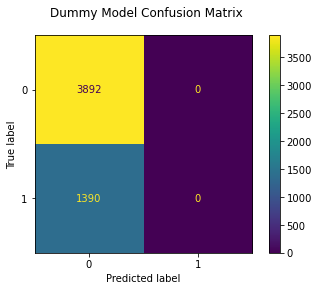

In [54]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(y_train, dummy_model.predict(X_train))).plot(ax=ax)

In [84]:
cross_val_score(dummy_model, X_train, y_train, cv=5).mean()

0.7368420486797971

At this point, our dummy model has a 73% accuracy score, and it will have 0% recall because it is a dummy model with no variation in its response - it predicts that a customer will not churn and it is correct 73% of the time. Obviously, 73% is not a very good score, and 0% is even worse, because remember that our biggest concern insofar as measurement metrics will be recall for this model. Therefore, the current score to beat is actually 0%, though we would love to see a better accuracy score as well.

First, we will instantiate a simple Decision Tree classifier to see if that alone performs better than our dummy model.

In [55]:
clf = tree.DecisionTreeClassifier()

In [56]:
clf.fit(X_train_encoded, encoded_y_train)

DecisionTreeClassifier()

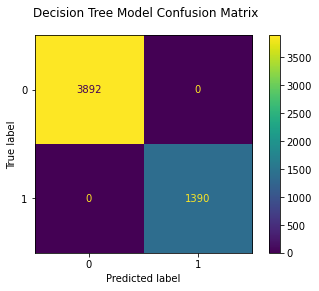

In [57]:
fig, ax = plt.subplots()

fig.suptitle("Decision Tree Model Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(encoded_y_train, clf.predict(X_train_encoded))).plot(ax=ax)

In [83]:
cross_val_score(clf, X_train_encoded, encoded_y_train, cv=5).mean()

0.9165091668816834

In [58]:
clf.score(X_train_encoded, encoded_y_train)

1.0

As we can see, our simple decision tree is very overfit. Rather than try to fiddle with the very simple decision tree that will be unlikely to get us anywhere really, I have decided to move into random forest modeling and tweak that instead so that I can find the best model for this job.

In [60]:
rfc = RandomForestClassifier()

In [61]:
rfc.fit(X_train_encoded, encoded_y_train)

RandomForestClassifier()

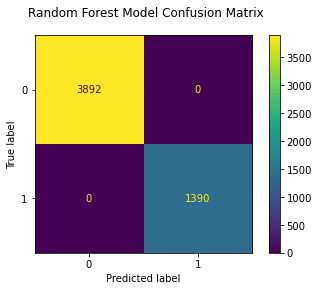

In [62]:
fig, ax = plt.subplots()

fig.suptitle("Random Forest Model Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(encoded_y_train, rfc.predict(X_train_encoded))).plot(ax=ax)

In [63]:
cross_val_score(rfc, X_train_encoded, encoded_y_train, cv=5).mean()

0.9341143817551103

In [64]:
rfc.score(X_train_encoded, encoded_y_train)

1.0

As we may have guessed, an unaltered random forest model presents us with the exact same information as an even simpler decision tree model. Now, it's time to start hypertuning our random forest so that we can reduce overfitting and begin to accurately predict whether or not a customer will churn. We will need to tune our model, but also deal with the previously mentioned class imbalance in our data - most of the customers did not churn, and so our models are assuming that most people will not churn.

Another thing to note is that we have done these models outside of a pipeline, mainly because they are very simple models that I expected to both overfit and not predict very well. Thusly, it was not strictly "necessary" to establish a modeling pipeline for these very simple models. We will do that now, and use GridSearchCV to further tune our model.

In [65]:
model_pipeline = Pipeline(steps=[('preprocessing', prep_pipeline),
                                ('classifier', rfc)])

In [66]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 5, 10],
    'classifier__class_weight': ['balanced'],
}

In [67]:
grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, cv=5)

In [68]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Multiple '
                                                                          'Lines',
                                                                          'Internet '
                                                                          'Service',
                                                                          'Online '
                                                                          'Security',
                                                                          'Online '
                                              

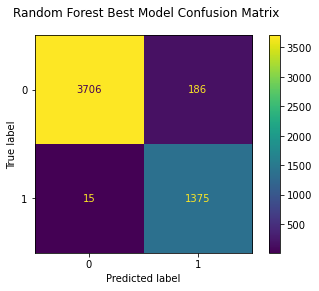

In [72]:
fig, ax = plt.subplots()

fig.suptitle("Random Forest Best Model Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(y_train, grid_search.predict(X_train))).plot(ax=ax)

In [74]:
cross_val_score(grid_search, X_train, y_train, cv=5).mean()

0.928433280295863

In [76]:
grid_search.score(X_train, y_train)

0.9619462324876941

In [77]:
ypred_final = grid_search.predict(X_train)

In [78]:
ypred_final_test = grid_search.predict(X_test)

In [79]:
accuracy_score(y_test, ypred_final_test)

0.9278818852924475

In [91]:
recall_score(y_test, ypred_final_test, pos_label='Yes')

0.9164926931106472

In [69]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [70]:
best_params

{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 10,
 'classifier__n_estimators': 200}

In [107]:
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract', 'Payment Method',
                                                   'Offer', 'Internet Type']),
                                    

Our last analytic step is to determine feature importance within the model so that we can move forward with advisable next steps for our client. In other words, which of these features impacts customer churn the most? Or the least? Anyway, so I did a bit of a stupid and I did not set up the Capstone environment that we were advised to set up, meaning I am working with an outdated version of sklearn that makes it more difficult to get the feature importances from models. This is my own fault, and also allows me to showcase that I do know how to do it, even the hard way.

In [92]:
feature_names = final_df.columns

In [93]:
feature_names

Index(['Senior Citizen', 'Partner', 'Dependents', 'Tenure', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Churn', 'Gender', 'Churn Score', 'CLTV', 'Referred a Friend',
       'Number of Referrals', 'Offer', 'Avg Monthly Long Distance Charges',
       'Internet Type', 'Avg Monthly GB Download', 'Streaming Music',
       'Unlimited Data', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue'],
      dtype='object')

In [96]:
importance = best_model.named_steps['classifier'].feature_importances_

In [97]:
feature_importance_dict = dict(zip(feature_names, importance))

In [100]:
sorted_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

In [101]:
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")

Internet Type: 0.0451818689025809
Streaming Music: 0.03662022165378656
Internet Service: 0.026104700116657425
Phone Service: 0.019701994873563215
Payment Method: 0.018258282065367625
Total Charges: 0.015141017536061901
Avg Monthly GB Download: 0.008036273805936347
Device Protection: 0.007682090127172556
Online Backup: 0.006001897739148898
Tenure: 0.00580461528190138
Tech Support: 0.005265893921926943
CLTV: 0.004934940339260185
Streaming Movies: 0.004813321145197046
Online Security: 0.004302902026467483
Contract: 0.004277002700420442
Offer: 0.004079012894716978
Multiple Lines: 0.00378497490824955
Gender: 0.0031709959964994422
Avg Monthly Long Distance Charges: 0.002781085035681401
Dependents: 0.0024689599949103565
Senior Citizen: 0.0024128794875905
Monthly Charge: 0.002320695624785774
Total Extra Data Charges: 0.002297806599552667
Paperless Billing: 0.0022042222098647623
Total Refunds: 0.002201189932872714
Referred a Friend: 0.0021294968759809074
Total Revenue: 0.0021172507371102554
Chu

# Model Recommendations

As we can see from the above use of best_model, our best iteration so far was a Random Forest with a class_weight balance to deal with our class imbalance issue, as well as 300 n-estimators and a max_depth of 10. It is very possible that with more iterations and tweaking, our model would perform even better. Sadly, due to time, life and computer constraints, this was the best model we could present in the time given.

# Conclusion

In conclusion, while the model itself may have been somewhat lackluster, the overall theory has been proven - it is possible to feed a random forest model customer data and predict whether or not a customer will churn. It is not possible to overstate the benefits of such a model, as it would allow companies to effectively churn back time on their customer expiration.

# Next Steps

A company using this model could effectively earmark customers that the model thinks will churn "soon" and take steps to prevent that behavior, such as reaching out to make a special offer or simply to check in with a customer that might be lost soon. Furthermore, because our data shows that 'Internet Type' is the most impactful feature in our model, it might be wise to research WHICH internet type is most likely to churn and reach out to those customers specifically.

# Citations

1 - "Mastering Random Forests: A Comprehensive Guide"
    Sandeep Ram
    Published in "Towards Data Science"
    October 18, 2020
    https://towardsdatascience.com/mastering-random-forests-a-comprehensive-guide-51307c129cb1#:~:text=max_depth%3A%20The%20number%20of%20splits,3%2C%205%2C%20or%207.
    
2 - "How to Cite Data and Code"
    Author Unlisted
    Iowa University Libraries
    Date Unlisted
    https://www.lib.uiowa.edu/data/cite-data-and-code/